**CS-C3240 - Machine Learning D**
**Project**

**Authors: Aaron Gutierrez-Hernandez & Alexandre Cojot**

**Date created: 10-sep-2023**

**Last modified: 05-oct-2023**

# Import Libraries and Data

In [1]:
# Import libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

# Read the .csv file containing the dataset
data = pd.read_csv('heart_data.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Clean Data

In [2]:
data.info() # check basic dataframe's information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [3]:
data.duplicated().sum() # look if there are duplicates

723

In [4]:
data.drop_duplicates(inplace=True) # drop druplicates

# EDA

In [5]:
data.describe() # basic descriptive statistics of the dataframe

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


<AxesSubplot:>

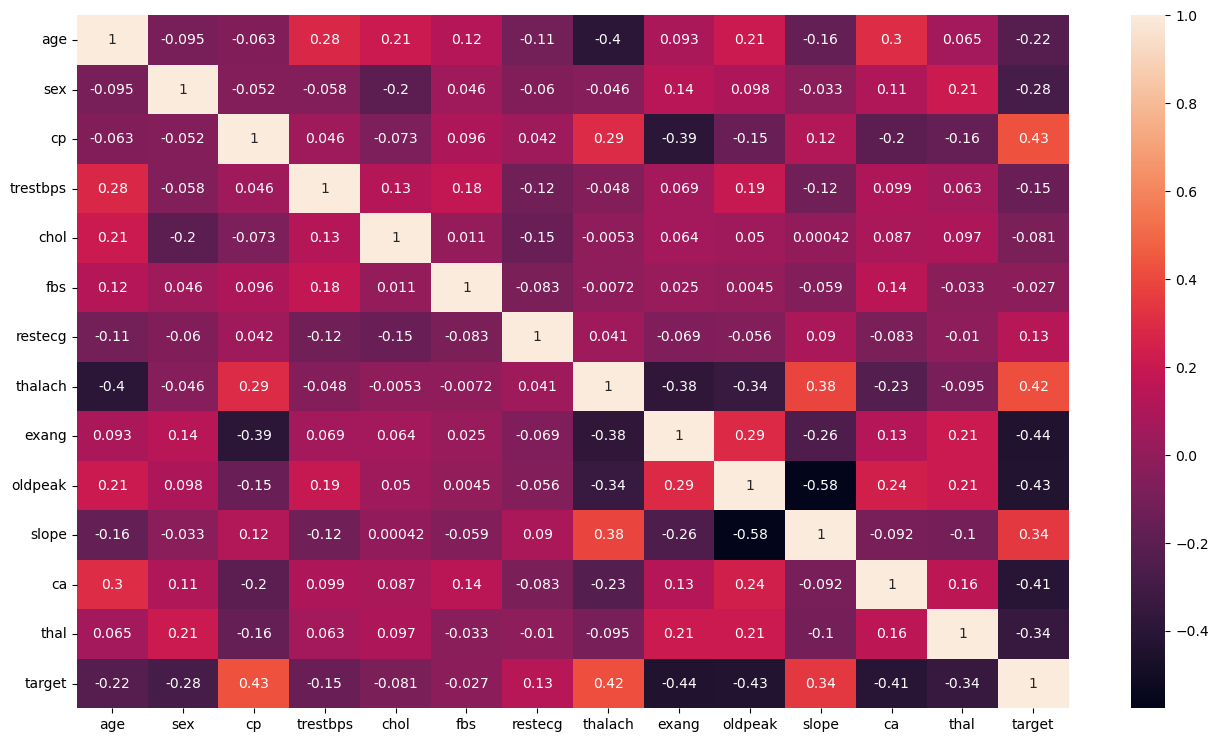

In [6]:
plt.figure(figsize=(16,9)) 
sns.heatmap(data.corr(),annot=True) # see correlation between features and features with response variable

<Figure size 1600x900 with 0 Axes>

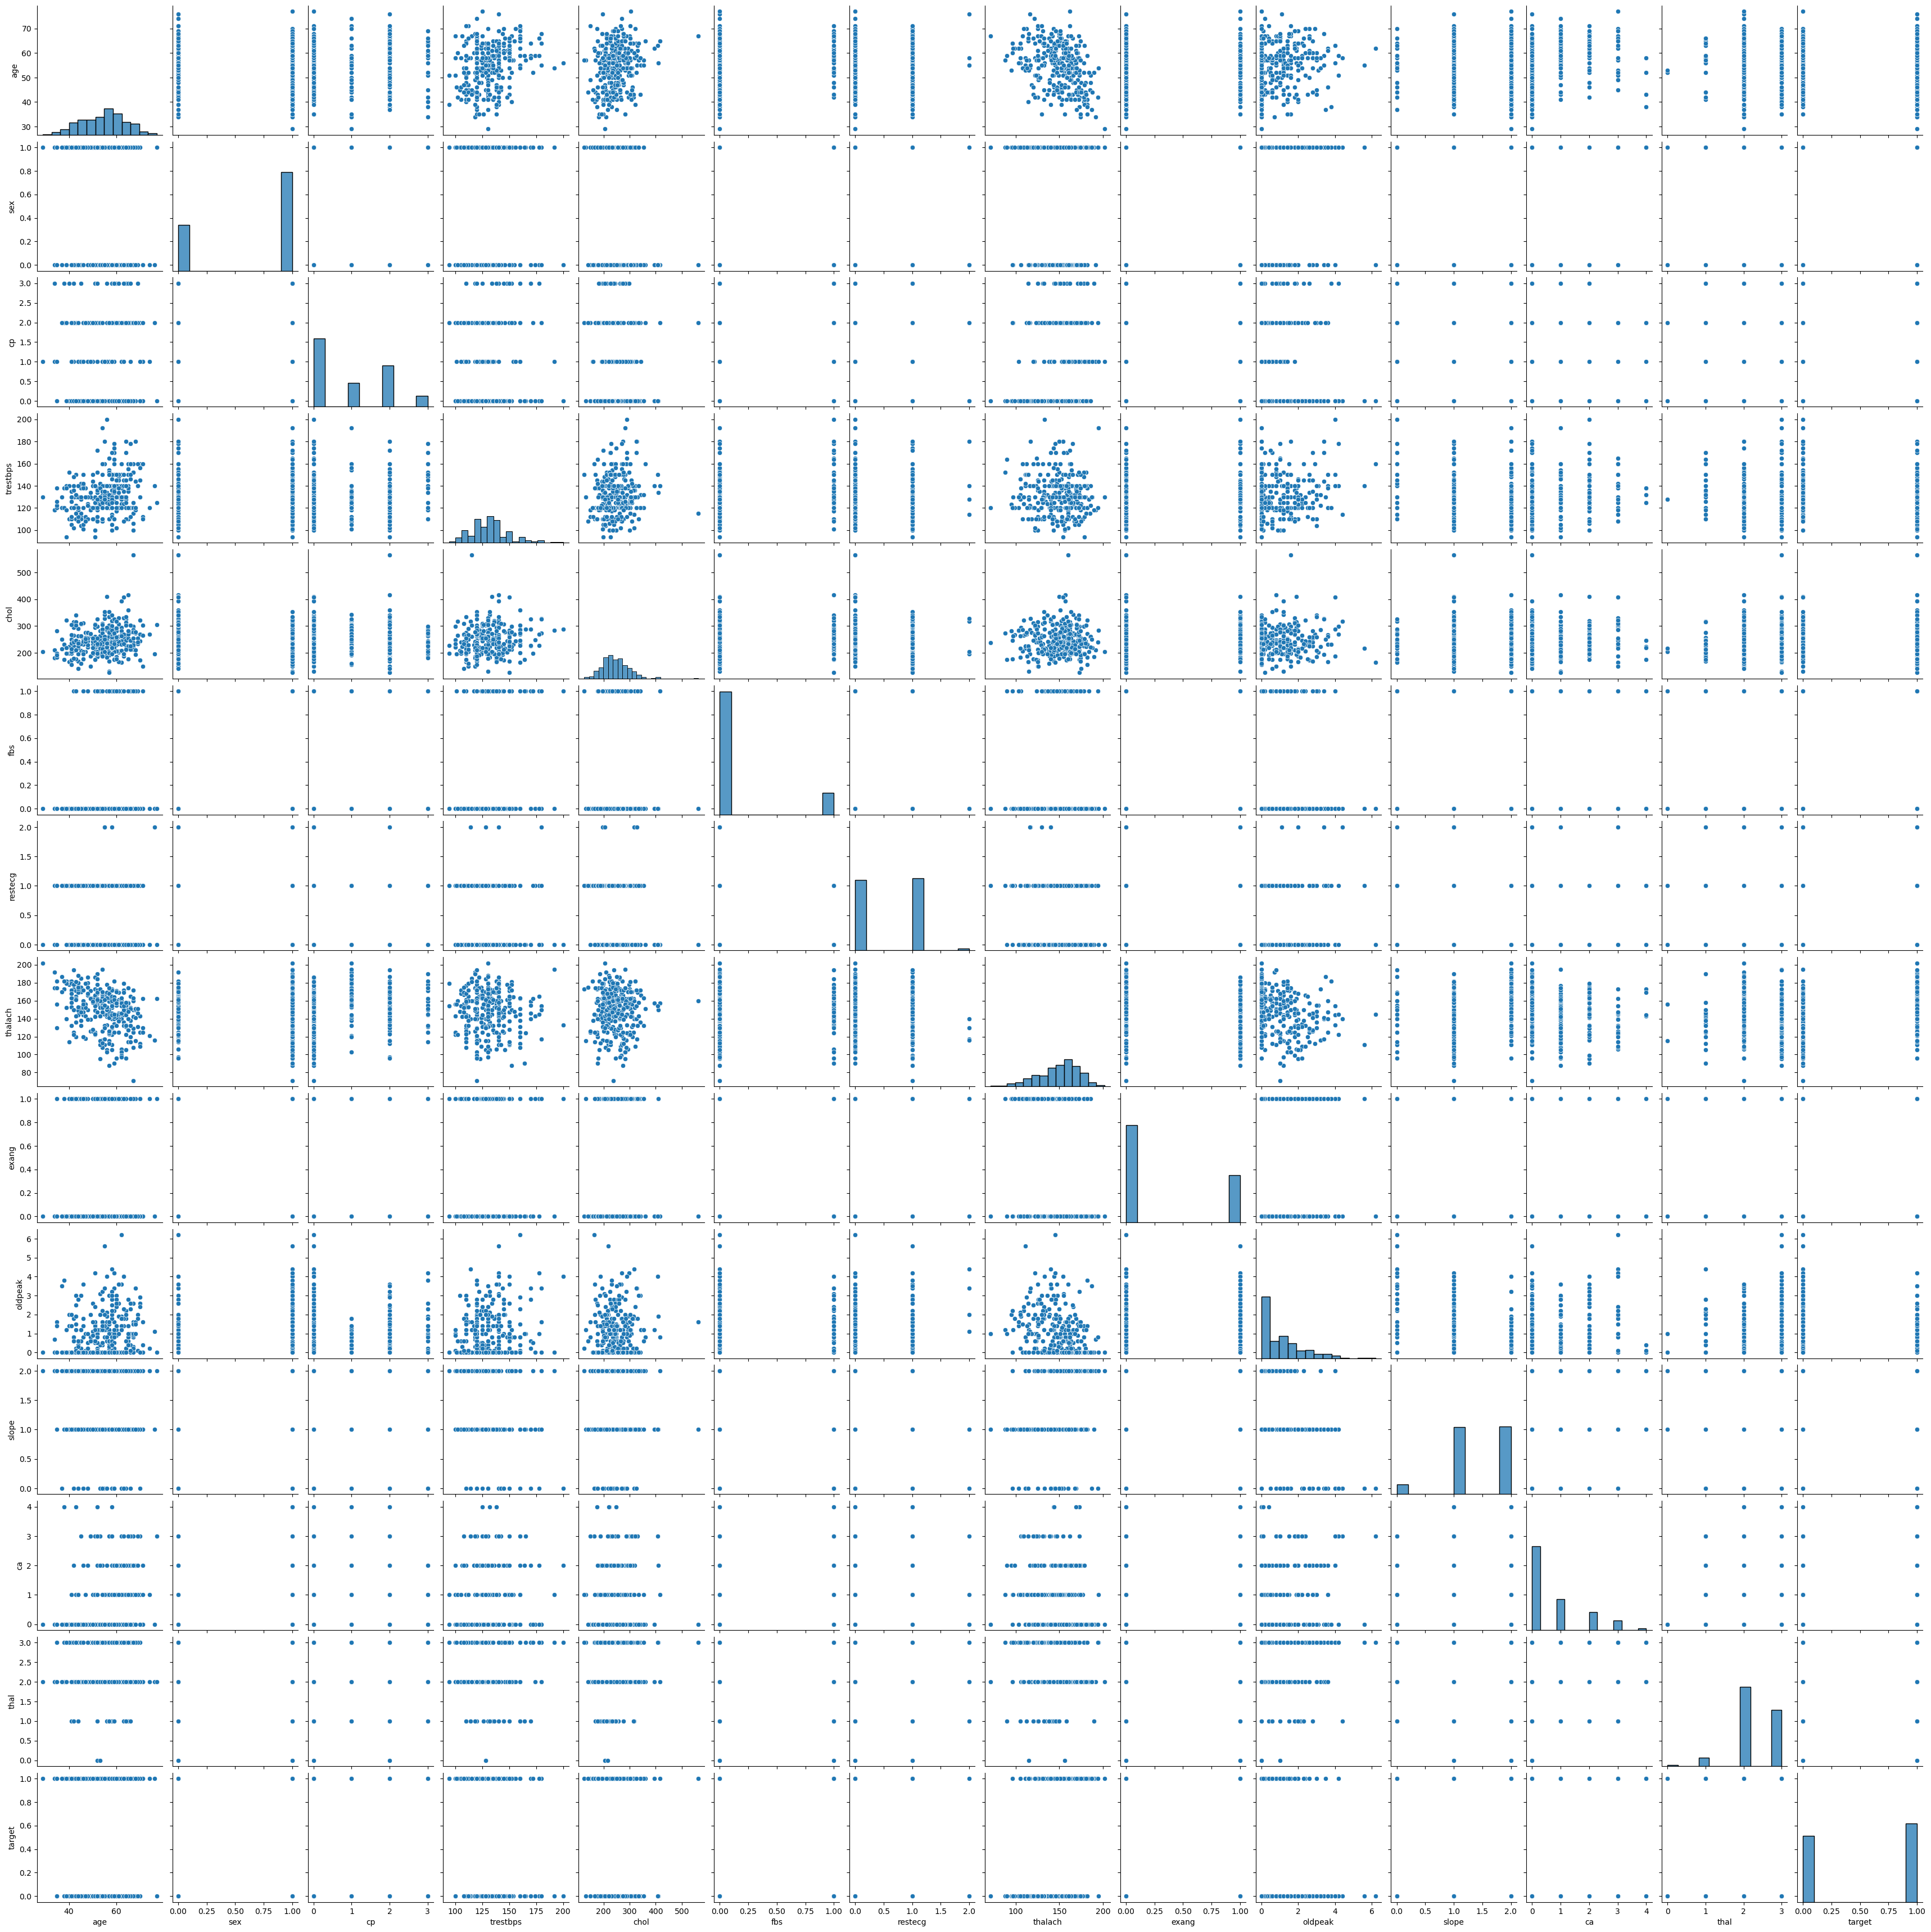

In [7]:
plt.figure(figsize=(16,9))
sns.pairplot(data) # see distribution between each pair of features and features with response variable

1    164
0    138
Name: target, dtype: int64
__________________________________________________
1    0.543046
0    0.456954
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='count'>

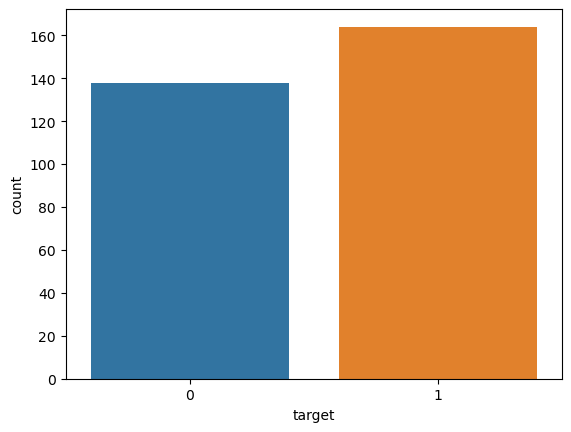

In [8]:
# Look at how the response variable is splitted to avoid fitting the model to just one value
target_counts = data['target'].value_counts() # count response variable values to see if they are not unbalanced
target_ratios = target_counts/len(data)       # get the same information in a ratios format
print(target_counts)
print(50*'_')
print(target_ratios)
sns.countplot(x=data['target'])

# Prepare Data

In [9]:
# Make categorical data to the corresponding features
categorical_features = ['sex','cp','fbs','restecg','exang','thal','target'] # columns containing categorical features 
data[categorical_features] = data[categorical_features].astype('category')  # converting dtype to categorical
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 878
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       302 non-null    int64   
 1   sex       302 non-null    category
 2   cp        302 non-null    category
 3   trestbps  302 non-null    int64   
 4   chol      302 non-null    int64   
 5   fbs       302 non-null    category
 6   restecg   302 non-null    category
 7   thalach   302 non-null    int64   
 8   exang     302 non-null    category
 9   oldpeak   302 non-null    float64 
 10  slope     302 non-null    int64   
 11  ca        302 non-null    int64   
 12  thal      302 non-null    category
 13  target    302 non-null    category
dtypes: category(7), float64(1), int64(6)
memory usage: 30.1 KB


In [10]:
# Standardize numerical features
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca'] # columns containing numerical features 
scaler = StandardScaler()          # initialize scaler
scaler.fit(data[numeric_features]) # fit the scaler to the selected numeric columns
data[numeric_features] = scaler.transform(data[numeric_features]) # standardize the numeric columns
data.describe() # basic descriptive statistics of the dataframe

,age,trestbps,chol,thalach,oldpeak,slope,ca
count,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02
mean,-2.721103e-16,-6.690748e-16,-4.411482e-18,-5.418771e-16,8.822964e-17,-1.158014e-16,-1.139633e-17
std,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00
min,-2.814192e+00,-2.144521e+00,-2.332210e+00,-3.436149e+00,-8.995441e-01,-2.271182e+00,-7.149112e-01
25%,-7.107878e-01,-6.617119e-01,-6.870826e-01,-7.137164e-01,-8.995441e-01,-6.458337e-01,-7.149112e-01
50%,1.195033e-01,-9.140084e-02,-1.161266e-01,1.281605e-01,-2.096081e-01,-6.458337e-01,-7.149112e-01
75%,7.283833e-01,4.789102e-01,5.467629e-01,7.185677e-01,4.803280e-01,9.795144e-01,2.800344e-01
max,2.499671e+00,3.900776e+00,6.145034e+00,2.292987e+00,4.447460e+00,9.795144e-01,3.264871e+00


In [11]:
X = data.drop('target',axis=1) # split the features from the labels
y = data['target']             # split the labels from the features
print(X.shape,y.shape)

(302, 13) (302,)


# ML Models

In [12]:
clfs = ([LogisticRegression(solver='liblinear', penalty='l2'),
         RandomForestClassifier(criterion='entropy',max_depth=5)]) # initialize proposed classifiers

## K-Fold Cross Validation

In [13]:
kf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # initialize k-folds
acc_valid = []                                                   # store validation accuracy
for clf in clfs:
    warnings.filterwarnings('ignore', category=FutureWarning)
    scrs = cross_val_score(clf, X, y, cv=kf, scoring='accuracy') # compute k-fold cross validation scores
    acc_valid.append(scrs.mean())
    print(70*'_')                                                
    print(clf)
    print(f'Scores: {scrs}')
    print(f'Scores mean: {scrs.mean():.4f}')

______________________________________________________________________
LogisticRegression(solver='liblinear')
Scores: [0.91803279 0.78688525 0.75       0.86666667 0.83333333]
Scores mean: 0.8310
______________________________________________________________________
RandomForestClassifier(criterion='entropy', max_depth=5)
Scores: [0.90163934 0.81967213 0.8        0.78333333 0.8       ]
Scores mean: 0.8209


## Split data

__________________________________________________
y_train
Set sizes
(241,) (241,)
Label counts
1    131
0    110
Name: target, dtype: int64
Label ratios
1    0.543568
0    0.456432
Name: target, dtype: float64


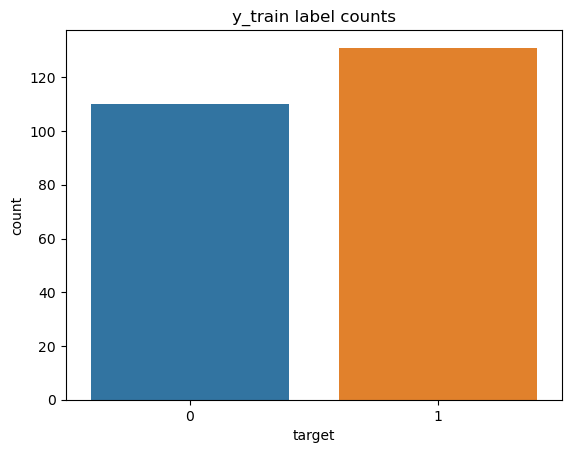

__________________________________________________
y_test
Set sizes
(61,) (61,)
Label counts
1    33
0    28
Name: target, dtype: int64
Label ratios
1    0.540984
0    0.459016
Name: target, dtype: float64


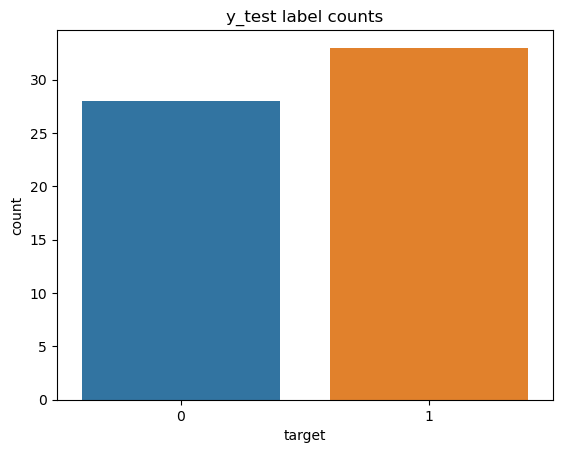

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    stratify=y, random_state=0) # split data in training and testing sets
y_sets = {'y_train': y_train, 'y_test': y_test}

for y_name, y_set in y_sets.items():
    y_counts = y_set.value_counts() # count response variable values to see if they are not unbalanced
    y_ratios = y_counts/len(y_set)  # get the same information in a ratios format
    print(50*'_')
    print(y_name)
    print('Set sizes')
    print(y_set.shape,y_set.shape)
    print('Label counts')
    print(y_counts)
    print('Label ratios')
    print(y_ratios)
    sns.countplot(x=y_set)
    plt.title(str(y_name)+' label counts')
    plt.show()

# Models evaluation

In [15]:
def plt_confmat(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', square=True, cbar= False,
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'],
                ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

____________________________________________________________
LogisticRegression(solver='liblinear')
Train Accuracy: 85.06 %
Test Accuracy : 88.52 %
Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.88      0.91      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



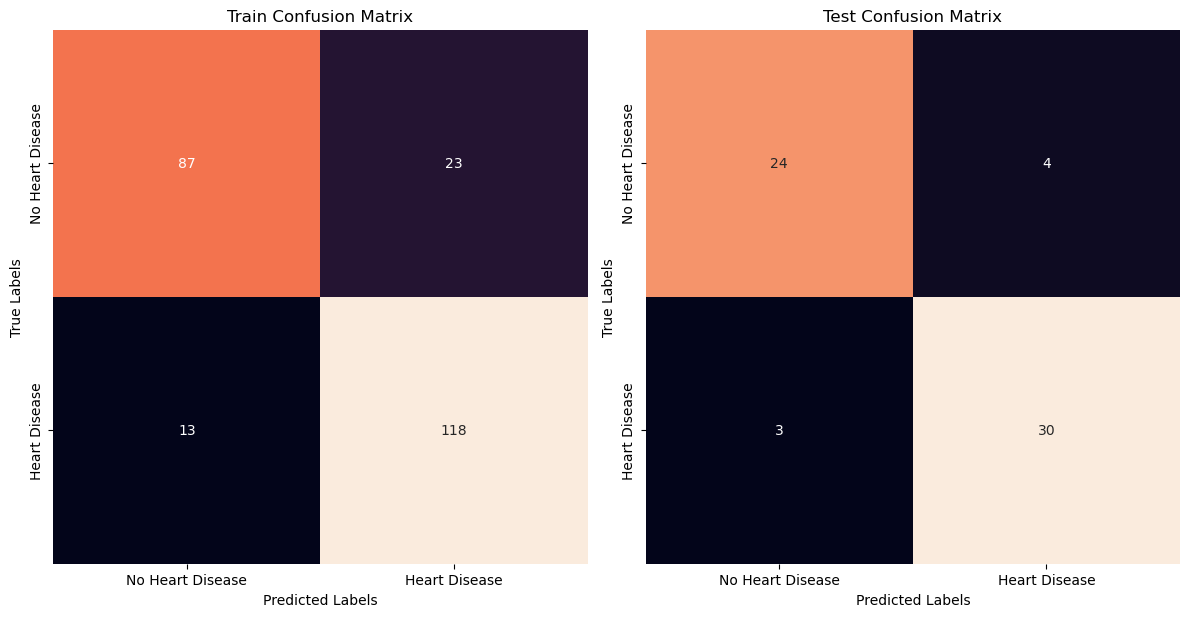

____________________________________________________________
RandomForestClassifier(criterion='entropy', max_depth=5)
Train Accuracy: 94.61 %
Test Accuracy : 90.16 %
Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.89      0.94      0.91        33

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



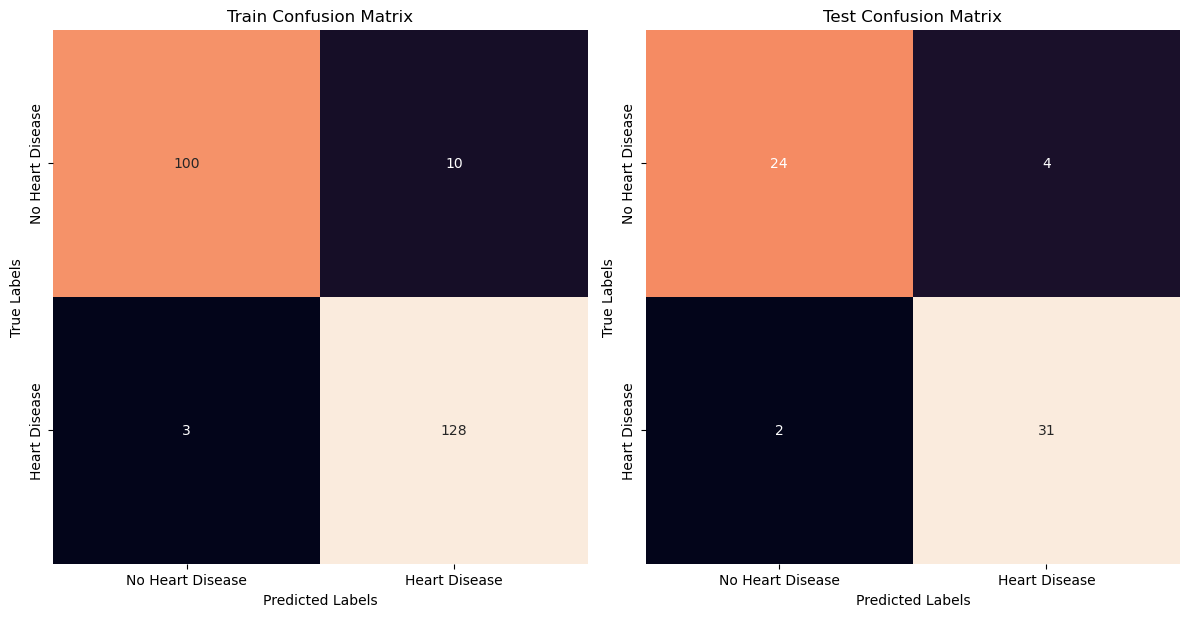

In [20]:
acc_train = []
acc_test  = []
for clf in clfs:
    clf.fit(X_train, y_train)         # train classifier (fit to training data)  
    y_pred = clf.predict(X_test)      # compute the predictions (use the trained model on test data) 
    train_pred = clf.predict(X_train) # compute the predictions (use the trained model on train data) 
    # Train and test scores
    train_score = accuracy_score(y_train, train_pred)
    test_score  = accuracy_score(y_test, y_pred)
    acc_train.append(train_score)
    acc_test.append(test_score)
    # Model evaluation metrics
    print(60*'_')                                                
    print(clf)
    print(f'Train Accuracy: {100*train_score:.2f}','%')
    print(f'Test Accuracy : {100*test_score:.2f}','%')
    print('Report:\n',classification_report(y_test, y_pred))
    # Visualize Confusion Matrices
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    plt_confmat(y_train, train_pred, 'Train Confusion Matrix', axes[0])
    plt_confmat(y_test, y_pred, 'Test Confusion Matrix', axes[1])
    plt.tight_layout()
    plt.show()

## Subset scores

In [21]:
df = pd.DataFrame(columns=['Logistic Regression', 'Random Forest'])
df.loc[0] = acc_train
df.loc[1] = acc_valid
df.loc[2] = acc_test
df.loc[3] = [1-acc for acc in acc_train]
df.loc[4] = [1-acc for acc in acc_valid]
df.loc[5] = [1-acc for acc in acc_test]
df.loc[6] = df.iloc[0:3].mean()
df.loc[7] = df.iloc[3:6].mean()
rows = {
    0: 'Training Accuracy',
    1: 'Validation Accuracy',
    2: 'Test Accuracy',
    3: 'Training Error',
    4: 'Validation Error',
    5: 'Test Error',
    6: 'Average Accuracy',
    7: 'Average Error'
}
df = df.rename(index=rows)
df = df.round(4)
df

,Logistic Regression,Random Forest
Training Accuracy,0.8506,0.9461
Validation Accuracy,0.8310,0.8209
Test Accuracy,0.8852,0.9016
Training Error,0.1494,0.0539
Validation Error,0.1690,0.1791
Test Error,0.1148,0.0984
Average Accuracy,0.8556,0.8895
Average Error,0.1444,0.1105


<Figure size 800x450 with 0 Axes>

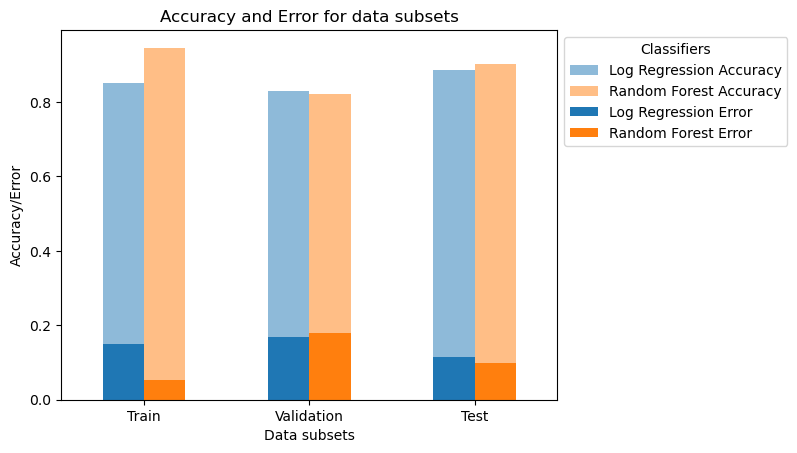

In [22]:
plt.figure(figsize=(8,4.5))
df[0:3].plot(kind='bar',rot=0,alpha=.5)
df[3:6].plot(kind='bar',rot=0,ax=plt.gca(), alpha=1)
plt.legend(title='Classifiers', loc='upper left', bbox_to_anchor=(1, 1),
           labels=['Log Regression Accuracy','Random Forest Accuracy',
                   'Log Regression Error   ','Random Forest Error'])
plt.xlabel('Data subsets')
plt.xticks([0,1,2],['Train','Validation','Test'])
plt.ylabel('Accuracy/Error')
plt.title('Accuracy and Error for data subsets')
plt.show()